In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc
)

sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)
df = pd.read_csv("german_credit.csv")

In [35]:
df.head(3)

,status_checking,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status,debtors,...,property,age,other_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   status_checking   1000 non-null   object
 1   duration          1000 non-null   int64 
 2   credit_history    1000 non-null   object
 3   purpose           1000 non-null   object
 4   credit_amount     1000 non-null   int64 
 5   savings           1000 non-null   object
 6   employment        1000 non-null   object
 7   installment_rate  1000 non-null   int64 
 8   personal_status   1000 non-null   object
 9   debtors           1000 non-null   object
 10  residence         1000 non-null   int64 
 11  property          1000 non-null   object
 12  age               1000 non-null   int64 
 13  other_plans       1000 non-null   object
 14  housing           1000 non-null   object
 15  existing_credits  1000 non-null   int64 
 16  job               1000 non-null   object
 17  dependents     

In [37]:
df.describe()

,duration,credit_amount,installment_rate,residence,age,existing_credits,dependents,credit_risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


In [38]:
print(df.isnull().sum())

status_checking     0
duration            0
credit_history      0
purpose             0
credit_amount       0
savings             0
employment          0
installment_rate    0
personal_status     0
debtors             0
residence           0
property            0
age                 0
other_plans         0
housing             0
existing_credits    0
job                 0
dependents          0
telephone           0
foreign_worker      0
credit_risk         0
dtype: int64


In [39]:
print("Target Value Distribution:")
print(df["credit_risk"].value_counts(normalize=True))

Target Value Distribution:
credit_risk
0    0.7
1    0.3
Name: proportion, dtype: float64


In [40]:
mappings = {
    'checking_account': {
        'A11': '< 0 DM',
        'A12': '0 <= ... < 200 DM',
        'A13': '>= 200 DM / salary 1yr+',
        'A14': 'no checking account'
    },
    'credit_history': {
        'A30': 'no credits / all paid',
        'A31': 'all credits paid (this bank)',
        'A32': 'credits paid till now',
        'A33': 'delay in past payments',
        'A34': 'critical account / other banks'
    },
    'purpose': {
        'A40': 'car (new)',
        'A41': 'car (used)',
        'A42': 'furniture/equipment',
        'A43': 'radio/television',
        'A44': 'domestic appliances',
        'A45': 'repairs',
        'A46': 'education',
        'A47': 'vacation (invalid)',
        'A48': 'retraining',
        'A49': 'business',
        'A410': 'others'
    },
    'savings': {
        'A61': '< 100 DM',
        'A62': '100 <= ... < 500 DM',
        'A63': '500 <= ... < 1000 DM',
        'A64': '>= 1000 DM',
        'A65': 'no savings / unknown'
    },
    'employment': {
        'A71': 'unemployed',
        'A72': '< 1 year',
        'A73': '1 <= ... < 4 years',
        'A74': '4 <= ... < 7 years',
        'A75': '>= 7 years'
    },
    'personal_status': {
        'A91': 'male : divorced/separated',
        'A92': 'female : div/sep/married',
        'A93': 'male : single',
        'A94': 'male : married/widowed',
        'A95': 'female : single'
    },
    'debtors': {
        'A101': 'none',
        'A102': 'co-applicant',
        'A103': 'guarantor'
    },
    'property': {
        'A121': 'real estate',
        'A122': 'building society/life insurance',
        'A123': 'car/other (not in savings)',
        'A124': 'unknown / no property'
    },
    'other_plans': {
        'A141': 'bank',
        'A142': 'stores',
        'A143': 'none'
    },
    'housing': {
        'A151': 'rent',
        'A152': 'own',
        'A153': 'for free'
    },
    'job': {
        'A171': 'unskilled - non-resident',
        'A172': 'unskilled - resident',
        'A173': 'skilled employee/official',
        'A174': 'management/self-employed/qualified'
    },
    'telephone': {
        'A191': 'none',
        'A192': 'yes, registered'
    },
    'foreign_worker': {
        'A201': 'yes',
        'A202': 'no'
    }
}

df_readable = df.copy()

for col, mapping in mappings.items():
    if col in df_readable.columns:
        df_readable[col] = df_readable[col].map(mapping)

df_readable.head()


,status_checking,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status,debtors,...,property,age,other_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,credit_risk
0,A11,6,critical account / other banks,radio/television,1169,no savings / unknown,>= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee/official,1,"yes, registered",yes,0
1,A12,48,credits paid till now,radio/television,5951,< 100 DM,1 <= ... < 4 years,2,female : div/sep/married,none,...,real estate,22,none,own,1,skilled employee/official,1,none,yes,1
2,A14,12,critical account / other banks,education,2096,< 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,0
3,A11,42,credits paid till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society/life insurance,45,none,for free,1,skilled employee/official,2,none,yes,0
4,A11,24,delay in past payments,car (new),4870,< 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown / no property,53,none,for free,2,skilled employee/official,2,none,yes,1


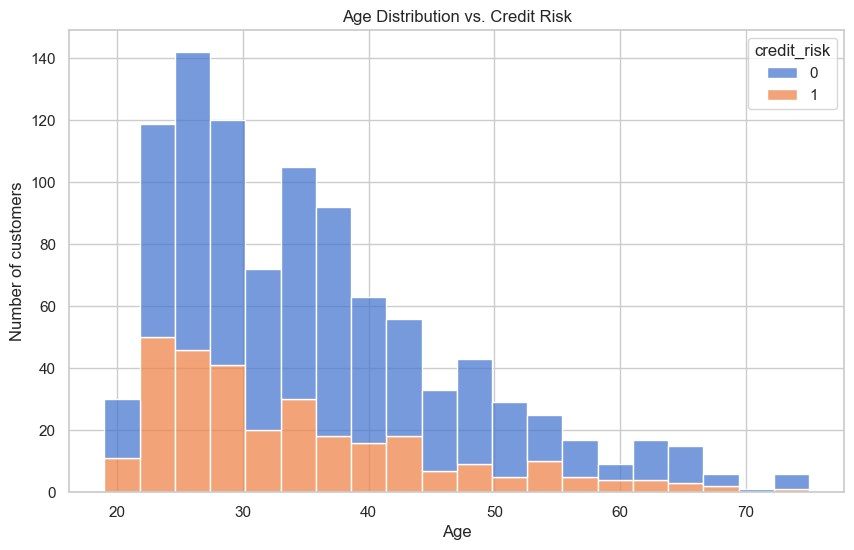

In [41]:
sns.histplot(data=df_readable, x='age', hue='credit_risk', multiple='stack', bins=20)
plt.title('Age Distribution vs. Credit Risk')
plt.xlabel('Age')
plt.ylabel('Number of customers')
plt.show()


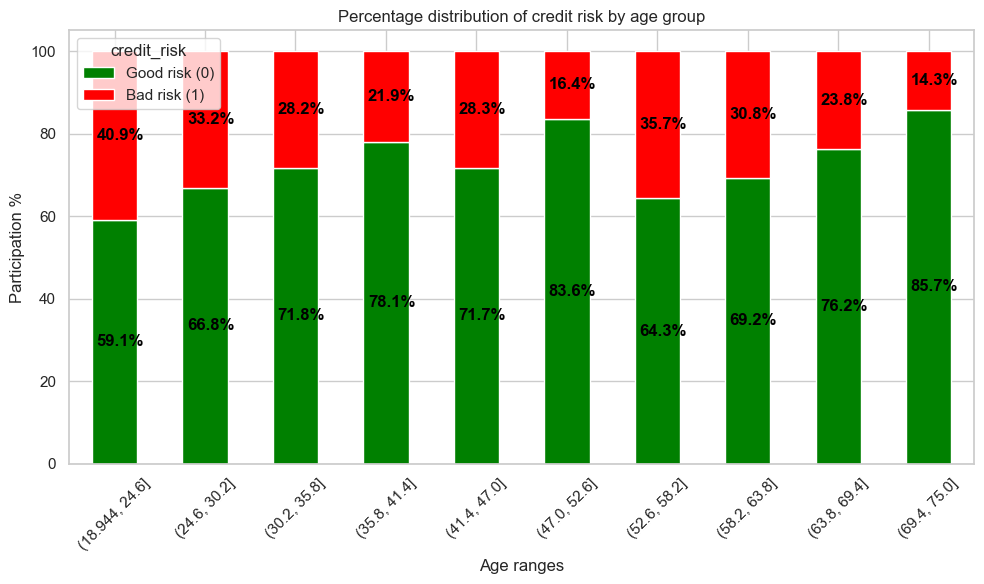

In [42]:
bins = pd.cut(df_readable['age'], bins=10)
age_risk = pd.crosstab(bins, df_readable['credit_risk'], normalize='index') * 100  # procentowo

age_risk.plot(kind='bar', stacked=True, color=['green', 'red'], figsize=(10, 6))

plt.title('Percentage distribution of credit risk by age group')
plt.xlabel('Age ranges')
plt.ylabel('Participation %')
plt.legend(title='credit_risk', labels=['Good risk (0)', 'Bad risk (1)'])
plt.xticks(rotation=45)

for i, total in enumerate(age_risk.values):
    good, bad = total
    plt.text(i - 0.2, good / 2, f'{good:.1f}%', color='black', va='center', fontweight='bold')
    plt.text(i - 0.2, good + bad / 2, f'{bad:.1f}%', color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


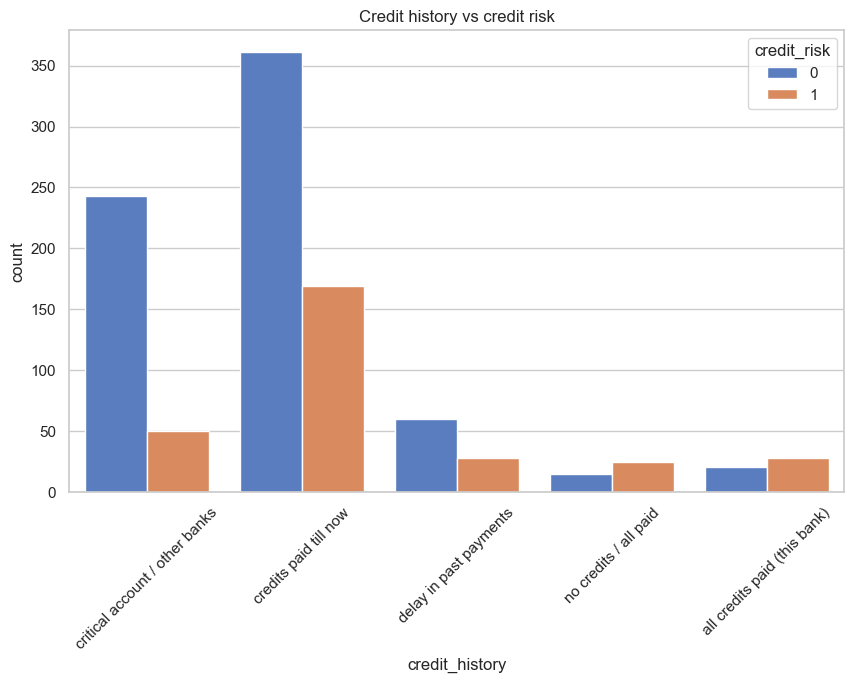

In [43]:
sns.countplot(data=df_readable, x='credit_history', hue='credit_risk')
plt.title('Credit history vs credit risk')
plt.xticks(rotation=45)
plt.show()


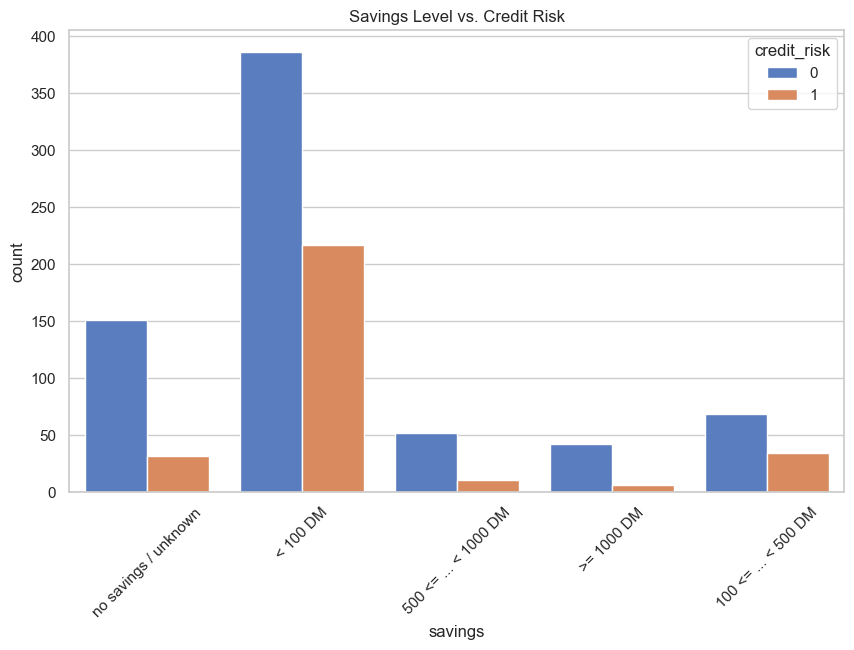

In [44]:
sns.countplot(data=df_readable, x='savings', hue='credit_risk')
plt.title('Savings Level vs. Credit Risk')
plt.xticks(rotation=45)
plt.show()


In [45]:
reverse_maps = {
    'status_checking': {
        '... < 0 DM': 'A11',
        '0 <= ... < 200 DM': 'A12',
        '>= 200 DM / salary >= 1yr': 'A13',
        'no checking account': 'A14'
    },
    'credit_history': {
        'no credits/all paid': 'A30',
        'all paid at this bank': 'A31',
        'credits paid till now': 'A32',
        'delay in past payments': 'A33',
        'critical account / other banks': 'A34'
    },
    'purpose': {
        'car (new)': 'A40',
        'car (used)': 'A41',
        'furniture/equipment': 'A42',
        'radio/television': 'A43',
        'domestic appliances': 'A44',
        'repairs': 'A45',
        'education': 'A46',
        'vacation': 'A47',
        'retraining': 'A48',
        'business': 'A49',
        'others': 'A410'
    },
    'savings': {
        '< 100 DM': 'A61',
        '100 <= ... < 500 DM': 'A62',
        '500 <= ... < 1000 DM': 'A63',
        '>= 1000 DM': 'A64',
        'no savings / unknown': 'A65'
    },
    'employment': {
        'unemployed': 'A71',
        '< 1 year': 'A72',
        '1 <= ... < 4 years': 'A73',
        '4 <= ... < 7 years': 'A74',
        '>= 7 years': 'A75'
    },
    'personal_status': {
        'male : divorced/separated': 'A91',
        'female : div/sep/married': 'A92',
        'male : single': 'A93',
        'male : married/widowed': 'A94',
        'female : single': 'A95'
    },
    'debtors': {
        'none': 'A101',
        'co-applicant': 'A102',
        'guarantor': 'A103'
    },
    'property': {
        'real estate': 'A121',
        'building society/life insurance': 'A122',
        'car or other': 'A123',
        'unknown / no property': 'A124'
    },
    'other_plans': {
        'bank': 'A141',
        'stores': 'A142',
        'none': 'A143'
    },
    'housing': {
        'rent': 'A151',
        'own': 'A152',
        'for free': 'A153'
    },
    'job': {
        'unemployed/ unskilled - non-resident': 'A171',
        'unskilled - resident': 'A172',
        'skilled employee/official': 'A173',
        'management/self-employed/highly qualified': 'A174'
    },
    'telephone': {
        'none': 'A191',
        'yes, registered': 'A192'
    },
    'foreign_worker': {
        'yes': 'A201',
        'no': 'A202'
    }
}


In [46]:
#Regression
df_ohe = pd.get_dummies(df, drop_first=True)

#Random Forest
df_rf = df.copy()
for col in df_rf.select_dtypes(include='object'):
    df_rf[col] = LabelEncoder().fit_transform(df_rf[col])


In [47]:
df_ohe.head()

,duration,credit_amount,installment_rate,residence,age,existing_credits,dependents,credit_risk,status_checking_A12,status_checking_A13,...,property_A124,other_plans_A142,other_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,telephone_A192,foreign_worker_A202
0,6,1169,4,4,67,2,1,0,False,False,...,False,False,True,True,False,False,True,False,True,False
1,48,5951,2,2,22,1,1,1,True,False,...,False,False,True,True,False,False,True,False,False,False
2,12,2096,2,3,49,1,2,0,False,False,...,False,False,True,True,False,True,False,False,False,False
3,42,7882,2,4,45,1,2,0,False,False,...,False,False,True,False,True,False,True,False,False,False
4,24,4870,3,4,53,2,2,1,False,False,...,True,False,True,False,True,False,True,False,False,False


In [48]:
df.head()

,status_checking,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status,debtors,...,property,age,other_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


In [50]:
X = df_ohe.drop('credit_risk', axis=1)
y = df_ohe['credit_risk']


In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [53]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [54]:
y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[122  18]
 [ 25  35]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       140
           1       0.66      0.58      0.62        60

    accuracy                           0.79       200
   macro avg       0.75      0.73      0.73       200
weighted avg       0.78      0.79      0.78       200



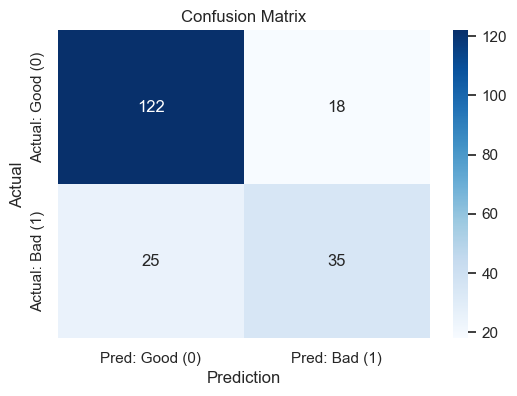

In [55]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Good (0)', 'Pred: Bad (1)'],
            yticklabels=['Actual: Good (0)', 'Actual: Bad (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()


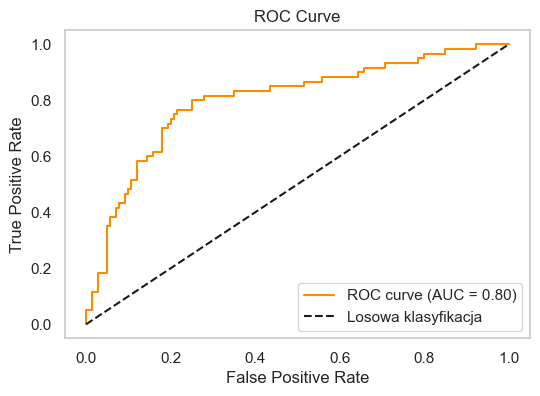

In [56]:
# Prawdopodobieństwa klasy 1 (czyli "Bad credit risk")
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Oblicz ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Wykres
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Losowa klasyfikacja')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


                feature  coefficient  abs_coefficient
9   status_checking_A14    -0.782411         0.782411
13   credit_history_A34    -0.639586         0.639586
32  personal_status_A93    -0.482885         0.482885
38        property_A124     0.453083         0.453083
42         housing_A153    -0.438921         0.438921
26          savings_A65    -0.427092         0.427092
14          purpose_A41    -0.402584         0.402584
2      installment_rate     0.391767         0.391767
29       employment_A74    -0.370712         0.370712
1         credit_amount     0.344474         0.344474


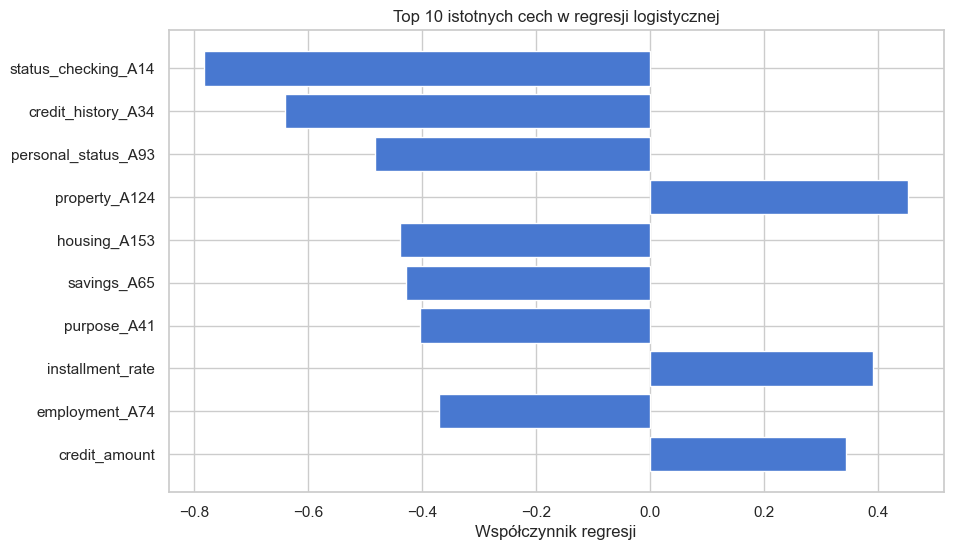

In [25]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': coefficients
})

feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()

feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

print(feature_importance.head(10))

plt.figure(figsize=(10,6))
plt.barh(feature_importance['feature'][:10], feature_importance['coefficient'][:10])
plt.xlabel('Współczynnik regresji')
plt.title('Top 10 istotnych cech w regresji logistycznej')
plt.gca().invert_yaxis()
plt.show()


In [57]:
# Model Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Prediction
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]


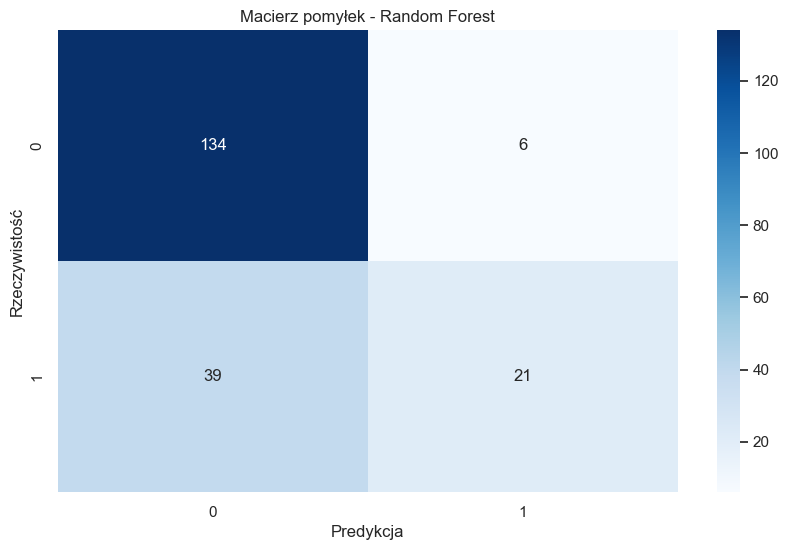

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       140
           1       0.78      0.35      0.48        60

    accuracy                           0.78       200
   macro avg       0.78      0.65      0.67       200
weighted avg       0.78      0.78      0.74       200



In [58]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predykcja")
plt.ylabel("Rzeczywistość")
plt.title("Macierz pomyłek - Random Forest")
plt.show()

print(classification_report(y_test, y_pred))


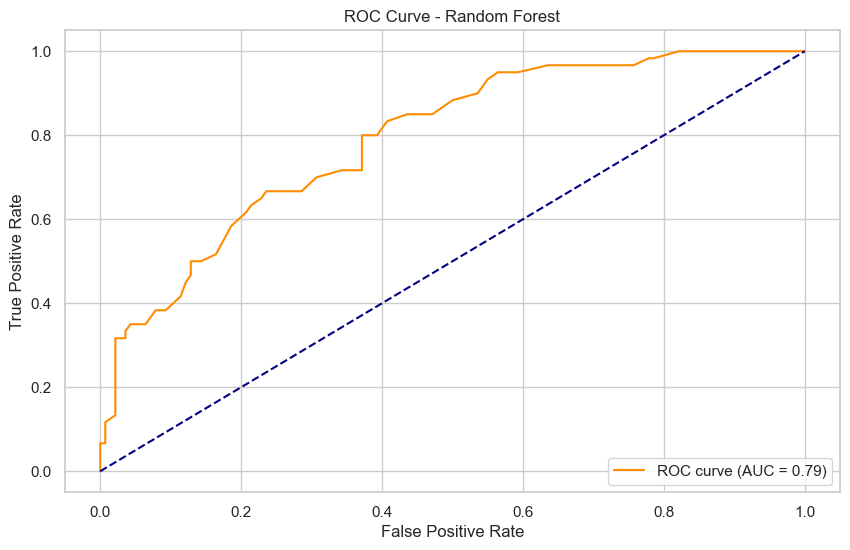

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


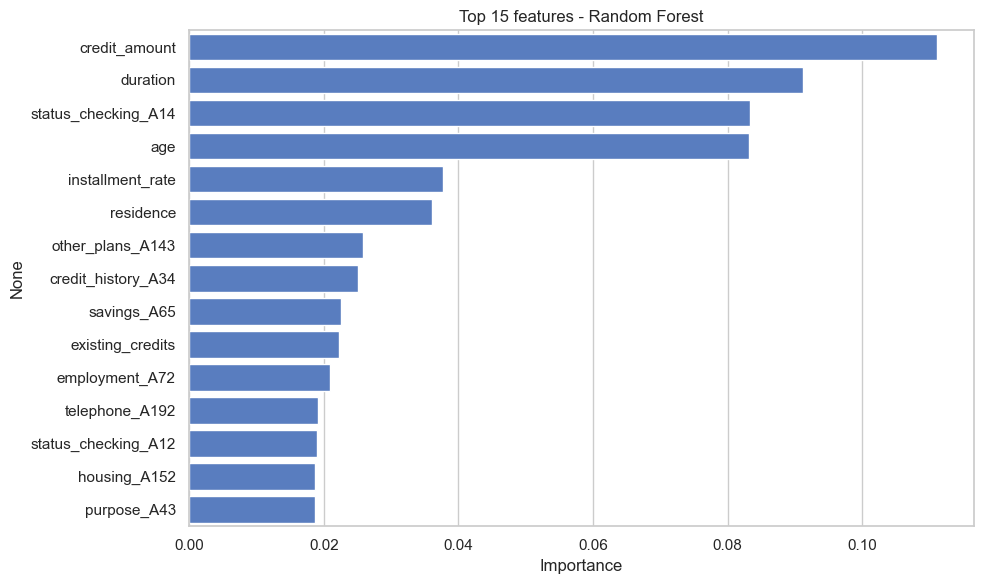

In [60]:
importances = rf_model.feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title('Top 15 features - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [61]:
y_pred_rf = rf_model.predict(X_test)



In [62]:
logreg_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

metrics = ['precision', 'recall', 'f1-score', 'support']

comparison_df = pd.DataFrame({
    'Logistic Regression (0)': [report_logreg['0'][m] for m in metrics],
    'Logistic Regression (1)': [report_logreg['1'][m] for m in metrics],
    'Random Forest (0)': [report_rf['0'][m] for m in metrics],
    'Random Forest (1)': [report_rf['1'][m] for m in metrics],
}, index=metrics).round(3)

print(comparison_df)


           Logistic Regression (0)  Logistic Regression (1)  \
precision                    0.892                    0.539   
recall                       0.707                    0.800   
f1-score                     0.789                    0.644   
support                    140.000                   60.000   

           Random Forest (0)  Random Forest (1)  
precision              0.775              0.778  
recall                 0.957              0.350  
f1-score               0.856              0.483  
support              140.000             60.000  
